In [168]:
import time
import random
from typing import Optional, List, Dict, Union, Any
from itertools import chain
from pathlib import Path

from selectorlib import Extractor
import requests
import pandas as pd
import plotly.express as px

In [2]:
extractor = Extractor.from_yaml_file('selectors.yml')

In [10]:
def scrape(url: str):
    headers = {
        'authority': 'www.amazon.com',
        'pragma': 'no-cache',
        'cache-control': 'no-cache',
        'dnt': '1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'sec-fetch-site': 'none',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-dest': 'document',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
    }

    # Download the page using requests
    print(f"Downloading {url}")
    r = requests.get(url, headers=headers)

    # Simple check to check if page was blocked (Usually 503)
    if r.status_code > 500:
        if "To discuss automated access to Amazon data please contact" in r.text:
            print("Page %s was blocked by Amazon. Please try using better proxies\n"%url)
        else:
            print("Page %s must have been blocked by Amazon as the status code was %d"%(url,r.status_code))
        return None

    # Pass the HTML of the page and create
    return extractor.extract(r.text)


def crawl(url: str, n_pages: Optional[int] = None) -> List[Dict[str, str]]:
    
    if n_pages is None:
        n_pages = float('inf')
    
    all_data = []
    
    counter = 0
    while counter < n_pages:
            
        try:
            data = scrape(url)
            time.sleep(random.randint(2, 10))
            all_data.append(data)

            pre_url = "https://www.amazon.com"
            url = pre_url + data['next_page']

            counter += 1

        except (KeyboardInterrupt, Exception):
            break
        
    return all_data


def format_reviews(data: List[Dict[str, str]]) -> pd.DataFrame:
    all_reviews = [review['reviews'] for review in data]
    return pd.DataFrame(list(chain(*all_reviews)))

In [4]:
URL = "https://www.amazon.com/Keychron-Wireless-Bluetooth-Mechanical-Keyboard/product-reviews/B07YB32H52/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"

In [5]:
data = crawl(URL)

In [11]:
df = format_reviews(data)

In [18]:
df.to_csv('keychron_K2_reviews.csv')

In [16]:
data[0]['product_title']

'Keychron K2 Wireless Bluetooth/USB Wired Gaming Mechanical Keyboard, Compact 84 Keys RGB LED Backlit N-Key Rollover Aluminum Frame for Mac Windows, Gateron Brown Switch, Version 2'

In [17]:
df

,title,content,date,variant,images,verified,author,rating
0,This is the best compromise I can find,"First off, unlike the other review currently u...","Reviewed in the United States on September 23,...",None,[https://images-na.ssl-images-amazon.com/image...,Verified Purchase,Dan,4.0 out of 5 stars
1,better than Gateron Brown -,Althgouh still prone to typos. I am goign to w...,"Reviewed in the United States on September 20,...",None,None,Verified Purchase,Isra Ignateous,4.0 out of 5 stars
2,"OK for the price, but not ""the one""",This keyboard has a lot to offer in a competit...,"Reviewed in the United States on January 6, 2020",Color: Gateron Red Switch v2,None,Verified Purchase,Carl,3.0 out of 5 stars
3,Simple... IT'S AMAZING!,"Well, there's not to much reviews about this k...","Reviewed in the United States on September 25,...",None,[https://images-na.ssl-images-amazon.com/image...,Verified Purchase,Arturo,5.0 out of 5 stars
4,I was not expecting to fall in love with the k...,Here's the story from the beginning. When I wa...,"Reviewed in the United States on May 21, 2020",None,None,Verified Purchase,Christ,5.0 out of 5 stars
...,...,...,...,...,...,...,...,...
568,None,Excelente teclado. El Bluetooth se conecta e i...,"Reviewed in Mexico on October 15, 2020",Color: Gateron Red Switch v2,None,Verified Purchase,Edwin,None
569,None,1,"Reviewed in Canada on July 23, 2020",Color: Gateron Red Switch v2,None,Verified Purchase,Miguel Wang,None
570,None,"It's great. Not perfect, but great.","Reviewed in Australia on February 23, 2021",Color: Gateron Red Switch v2,None,Verified Purchase,Samuel Nielsen,None
571,None,Love it,"Reviewed in Australia on August 15, 2020",Color: Gateron Brown Switch v2,None,Verified Purchase,wei cui,None


In [43]:
def format_rating(rating: str) -> Union[float, None]:
    try:
        rate = rating.split()[0]
        return eval(rate)
    except (AttributeError, IndexError):
        pass

In [24]:
df_copy = df.copy(deep=True)

In [46]:
df_copy.rating = df_copy.rating.apply(format_rating)

,title,content,date,variant,images,verified,author,rating
0,This is the best compromise I can find,"First off, unlike the other review currently u...","Reviewed in the United States on September 23,...",None,[https://images-na.ssl-images-amazon.com/image...,Verified Purchase,Dan,4.0
1,better than Gateron Brown -,Althgouh still prone to typos. I am goign to w...,"Reviewed in the United States on September 20,...",None,None,Verified Purchase,Isra Ignateous,4.0
2,"OK for the price, but not ""the one""",This keyboard has a lot to offer in a competit...,"Reviewed in the United States on January 6, 2020",Color: Gateron Red Switch v2,None,Verified Purchase,Carl,3.0
3,Simple... IT'S AMAZING!,"Well, there's not to much reviews about this k...","Reviewed in the United States on September 25,...",None,[https://images-na.ssl-images-amazon.com/image...,Verified Purchase,Arturo,5.0
4,I was not expecting to fall in love with the k...,Here's the story from the beginning. When I wa...,"Reviewed in the United States on May 21, 2020",None,None,Verified Purchase,Christ,5.0
...,...,...,...,...,...,...,...,...
568,None,Excelente teclado. El Bluetooth se conecta e i...,"Reviewed in Mexico on October 15, 2020",Color: Gateron Red Switch v2,None,Verified Purchase,Edwin,NaN
569,None,1,"Reviewed in Canada on July 23, 2020",Color: Gateron Red Switch v2,None,Verified Purchase,Miguel Wang,NaN
570,None,"It's great. Not perfect, but great.","Reviewed in Australia on February 23, 2021",Color: Gateron Red Switch v2,None,Verified Purchase,Samuel Nielsen,NaN
571,None,Love it,"Reviewed in Australia on August 15, 2020",Color: Gateron Brown Switch v2,None,Verified Purchase,wei cui,NaN


In [58]:
px.histogram(df_copy.rating, marginal='box')

In [64]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/d.e.magno/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [21]:
vds = SentimentIntensityAnalyzer()

In [22]:
def label_sentiment(text: str) -> int:
    sentiment_stats = vds.polarity_scores(text)
    sentiment = sentiment_stats['compound']
    
    if sentiment >= 0.05:
        return 1
    elif (sentiment > -0.05) and (sentiment < 0.05):
        return 0
    else:
        return -1

In [25]:
df_copy = df.copy(deep=True)

In [38]:
df_copy['sentiment'] = df_copy.content.apply(lambda x: label_sentiment(x) if isinstance(x, str) else x)

In [41]:
df_copy

,title,content,date,variant,images,verified,author,rating,sentiment
0,This is the best compromise I can find,"First off, unlike the other review currently u...","Reviewed in the United States on September 23,...",NaN,['https://images-na.ssl-images-amazon.com/imag...,Verified Purchase,Dan,4.0 out of 5 stars,1.0
1,better than Gateron Brown -,Althgouh still prone to typos. I am goign to w...,"Reviewed in the United States on September 20,...",NaN,NaN,Verified Purchase,Isra Ignateous,4.0 out of 5 stars,-1.0
2,"OK for the price, but not ""the one""",This keyboard has a lot to offer in a competit...,"Reviewed in the United States on January 6, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Carl,3.0 out of 5 stars,1.0
3,Simple... IT'S AMAZING!,"Well, there's not to much reviews about this k...","Reviewed in the United States on September 25,...",NaN,['https://images-na.ssl-images-amazon.com/imag...,Verified Purchase,Arturo,5.0 out of 5 stars,1.0
4,I was not expecting to fall in love with the k...,Here's the story from the beginning. When I wa...,"Reviewed in the United States on May 21, 2020",NaN,NaN,Verified Purchase,Christ,5.0 out of 5 stars,1.0
...,...,...,...,...,...,...,...,...,...
568,NaN,Excelente teclado. El Bluetooth se conecta e i...,"Reviewed in Mexico on October 15, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Edwin,NaN,1.0
569,NaN,1,"Reviewed in Canada on July 23, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Miguel Wang,NaN,0.0
570,NaN,"It's great. Not perfect, but great.","Reviewed in Australia on February 23, 2021",Color: Gateron Red Switch v2,NaN,Verified Purchase,Samuel Nielsen,NaN,1.0
571,NaN,Love it,"Reviewed in Australia on August 15, 2020",Color: Gateron Brown Switch v2,NaN,Verified Purchase,wei cui,NaN,1.0


In [2]:
data_path = lambda filename: Path.joinpath(Path.cwd().parent, 'data', filename)

In [14]:
df = pd.read_csv(data_path('keychron_K2_reviews.csv')).

In [18]:
df = df.drop(df.columns[0], axis=1)

In [42]:
df_copy

,title,content,date,variant,images,verified,author,rating,sentiment
0,This is the best compromise I can find,"First off, unlike the other review currently u...","Reviewed in the United States on September 23,...",NaN,['https://images-na.ssl-images-amazon.com/imag...,Verified Purchase,Dan,4.0 out of 5 stars,1.0
1,better than Gateron Brown -,Althgouh still prone to typos. I am goign to w...,"Reviewed in the United States on September 20,...",NaN,NaN,Verified Purchase,Isra Ignateous,4.0 out of 5 stars,-1.0
2,"OK for the price, but not ""the one""",This keyboard has a lot to offer in a competit...,"Reviewed in the United States on January 6, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Carl,3.0 out of 5 stars,1.0
3,Simple... IT'S AMAZING!,"Well, there's not to much reviews about this k...","Reviewed in the United States on September 25,...",NaN,['https://images-na.ssl-images-amazon.com/imag...,Verified Purchase,Arturo,5.0 out of 5 stars,1.0
4,I was not expecting to fall in love with the k...,Here's the story from the beginning. When I wa...,"Reviewed in the United States on May 21, 2020",NaN,NaN,Verified Purchase,Christ,5.0 out of 5 stars,1.0
...,...,...,...,...,...,...,...,...,...
568,NaN,Excelente teclado. El Bluetooth se conecta e i...,"Reviewed in Mexico on October 15, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Edwin,NaN,1.0
569,NaN,1,"Reviewed in Canada on July 23, 2020",Color: Gateron Red Switch v2,NaN,Verified Purchase,Miguel Wang,NaN,0.0
570,NaN,"It's great. Not perfect, but great.","Reviewed in Australia on February 23, 2021",Color: Gateron Red Switch v2,NaN,Verified Purchase,Samuel Nielsen,NaN,1.0
571,NaN,Love it,"Reviewed in Australia on August 15, 2020",Color: Gateron Brown Switch v2,NaN,Verified Purchase,wei cui,NaN,1.0


In [125]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

In [53]:
reviews = df_copy.content.apply(lambda x: word_tokenize(x) if isinstance(x, str) else x)

In [141]:
stop_words = set(stopwords.words('english') + ["can\'t"])

In [142]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 

In [51]:
def remove_stopwords(tokens: str) -> List[str]:
    return [word for word in tokens if not word in stop_words]

In [57]:
reviews

0      [First, off, ,, unlike, the, other, review, cu...
1      [Althgouh, still, prone, to, typos, ., I, am, ...
2      [This, keyboard, has, a, lot, to, offer, in, a...
3      [Well, ,, there, 's, not, to, much, reviews, a...
4      [Here, 's, the, story, from, the, beginning, ....
                             ...                        
568    [Excelente, teclado, ., El, Bluetooth, se, con...
569                                                  [1]
570    [It, 's, great, ., Not, perfect, ,, but, great...
571                                           [Love, it]
572                                                  NaN
Name: content, Length: 573, dtype: object

In [69]:
filtered_reviews = reviews.apply(lambda x: remove_stopwords(x) if isinstance(x, list) else x)

In [78]:
sample = filtered_reviews[0]

In [77]:
import re

In [81]:
' '.join(sample)

"First , unlike review currently right I n't find making typing errors I blame keyboard . I use mostly work I type A LOT , pretty much I write e-mails day , chat coworkers small amount programming . Programming course ca n't typos , otherwise things simply n't work . Likewise , e-mails instructions people technical . A typo could make difference world I trying convey . If keyboard type 100 % correctly I would sending back . That simply case . If 're wondering ; I connected via Bluetooth HP laptop runs Windows 10 . My laptop line-of-sight keyboard ; physical obstructions two 're maybe grand total three feet . Anyway , covers probably reliability typing , rest ? Well personally keyboard I seen comes close ticking boxes , needs wants : -Mechanical -Wireless -84-key -Aluminum deck -USB-C So compromise ? Well , n't Cherry switches , price wo n't get . Nevertheless , I n't complaints Gatereon switches . They 're smooth feel great type . Ca n't say I much experience Reds though , I like . Sec

In [169]:
def pipe(raw_input: Any, *functions, **functions_with_args) -> Any:
    """
    Creates a pipeline (or chain) for every function. Basically,
    this function initially accepts a data then passes it to the next
    function, then the output passes it to the next function as input.
    Args:
        raw_input (Any): Any input, could be list, tuple, etc.
    Other Parameters:
        param1 (Callable): Any function with only one argument.
        param2 (Callable): Any function with only one argument.
        ...
    Keyword Args:
        key1 (Callable): Any function with one or more than one
            arguments with arguments written as list.
        key2 (Callable): Any function with one or more than one
            arguments with arguments written as list.
        ...
    Returns:
        Any: Any output as a result of the functions it goes through.
    """

    # TODO: Needs more improvement for robustness.
    # Currently it will only work for some cases.
    output = raw_input

    if functions:
        for function in functions:
            output = function(output)

    if functions_with_args:
        for function, args_list in functions_with_args.items():
            output = eval(function)(output, *args_list)

    return output

In [171]:
def remove_possessive(text: str) -> str:
    pattern = r"(\'s)"
    return re.sub(pattern, "", text).strip()


def remove_punctuations(text: str) -> str:
    pattern = r"[^\w\s]"
    return re.sub(pattern, "", text).strip()


def remove_doublespace(text: str) -> str:
    pattern = r" +"
    return re.sub(pattern, " ", text).strip()


def remove_single(text: str) -> str:
    pattern = r"\b[a-zA-Z]\b"
    return re.sub(pattern, "", text)


def remove_specific(text: str) -> str:
    pattern = r"nt"
    return re.sub(pattern, "", text)


def clean_text(text: str) -> str:
    return pipe(
        text,
        remove_punctuations,
        remove_single,
        remove_specific,
        remove_doublespace
    )

In [144]:
sample_text = ' '.join(sample).strip()

In [172]:
cleaned_text = clean_text(sample_text)

In [176]:
freq = nltk.FreqDist(cleaned_text.split())

In [181]:
freq.most_common(20)

[('keyboard', 12),
 ('It', 8),
 ('typing', 7),
 ('work', 6),
 ('wireless', 5),
 ('never', 5),
 ('day', 4),
 ('would', 4),
 ('well', 4),
 ('IS', 4),
 ('type', 3),
 ('If', 3),
 ('re', 3),
 ('laptop', 3),
 ('USBC', 3),
 ('switches', 3),
 ('like', 3),
 ('nice', 3),
 ('bit', 3),
 ('every', 3)]

In [183]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [187]:
nltk.pos_tag(['cute', 'lovely', 'beautiful'])

[('cute', 'NN'), ('lovely', 'RB'), ('beautiful', 'JJ')]

In [192]:
adjectives = [x for (x,y) in nltk.pos_tag(cleaned_text.split()) if y in ('JJ')]

In [195]:
' '.join(adjectives)

'right much small technical laptop laptop physical grand total ticking smooth great much connector plan plugged ll nice alas tiny enough key enough last sleep start wireless mechanical gold inbetween feels nice nice unique short sure last remember full tl wireless mechanical couple backlit low second solid red reactive normal ten inactivity keyboard laptop whole weekday fair half steady usage noticed last next stop mean wa'

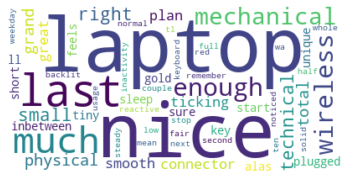

In [200]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white').generate(' '.join(adjectives))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
